In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
wave_len = 1600
window_size = 4
data_dim = 2
latent_dim = 64

In [3]:
def res_block(inputs, filters, kernel_size, strides=(1, 1), activation=tf.nn.relu, kernel_initializer=None):
    x = inputs

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x)

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x + inputs)

    return x

def leaky_relu(x, alpha):
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def encoder(inputs):
    h = 64
    initializer = tf.random_normal_initializer(0, 0.02)

    x = inputs

    # -------
    x = tf.layers.conv2d(x, h, kernel_size=(window_size, 1), strides=(1, 1), padding="same", kernel_initializer=initializer) # 2->h
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 1600*1*h -> 400*1*h
    
    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 400*1*h -> 100*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 100*1*h -> 25*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)

    # -------
    x = tf.reshape(x, shape=(-1, h * 25))
    x = tf.layers.dense(x, latent_dim, kernel_initializer=initializer) # 1024
    
    x = tf.nn.tanh(x)

    return x

def decoder(inputs):
    h = 64
    initializer = tf.random_normal_initializer(0, 0.02)
    
    x = inputs # 1600
    
    # -------
    x = tf.layers.dense(x, h * 25, kernel_initializer=initializer) # 64*25 = 1600
    x = tf.reshape(x, shape=(-1, 25, 1, h)) # 25*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 100*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 400*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 1600*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.conv2d(x, data_dim, kernel_size=1, padding="same", kernel_initializer=initializer)

    return x

In [4]:
inputs = tf.placeholder(tf.float32, (None, wave_len, data_dim))

encoded = encoder(tf.reshape(inputs, (-1, wave_len, 1, data_dim)))
decoded = tf.reshape(decoder(encoded), (-1, wave_len, data_dim))

In [5]:
inputs_fft_0 = tf.fft(tf.cast(inputs[:,:,0],tf.complex64))
inputs_fft_1 = tf.fft(tf.cast(inputs[:,:,1],tf.complex64))
decoded_fft_0 = tf.fft(tf.cast(decoded[:,:,0],tf.complex64))
decoded_fft_1 = tf.fft(tf.cast(decoded[:,:,1],tf.complex64))

In [6]:
# lr = 8e-4
# beta1= 0.5
# beta2 = 0.9
loss = tf.reduce_mean(tf.pow(tf.abs(inputs_fft_0 - decoded_fft_0),2)+tf.pow(tf.abs(inputs_fft_1 - decoded_fft_1),2)) # pow
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

(10370160, 2) 48000


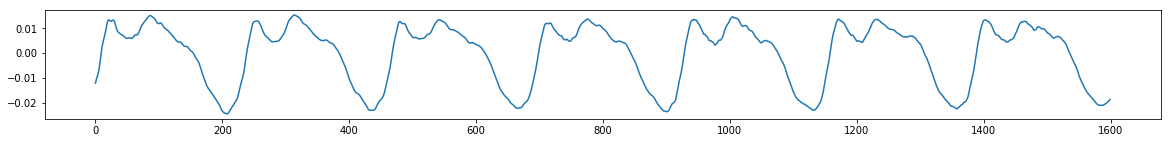

['../tamaneuta/trim_data/utama1.wav',
 '../tamaneuta/trim_data/utama2.wav',
 '../tamaneuta/trim_data/utama3.wav',
 '../tamaneuta/trim_data/utama4.wav',
 '../tamaneuta/trim_data/utama5.wav',
 '../tamaneuta/trim_data/utama6.wav',
 '../tamaneuta/trim_data/utama7.wav',
 '../tamaneuta/trim_data/utama8.wav',
 '../tamaneuta/trim_data/utama9.wav']

In [8]:
import soundfile as sf
import os

path = "../OriginalData/tamaneuta/trim_data/"
files = sorted(os.listdir(path))
files = [path + file for file in files]

data1, rate = sf.read(files[0]) # rate == 48000 # samplerate:1秒あたりのフレーム数
print(data1.shape, rate)
_s = 1000000
_data1 = data1[_s:_s+wave_len,0]
plt.figure(figsize=(20,2));plt.plot(_data1);plt.show()

files

In [9]:
import random

class Generator(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
        
        for i in range(0, int(len(wave)/wave_len)):
            _data = wave[i*wave_len:(i+1)*wave_len]
            _amp = np.max(np.abs(_data))
            if NO_SILENT and _amp < 0.005: # 無音を捨てる
                continue
            data.append(_data/_amp)
            amp.append(_amp)

        if shuffle:
            temp = list(zip(data, amp))
            np.random.shuffle(temp)
            data, amp = zip(*temp)
        
        data = np.array(data)
        amp = np.array(amp)
        
        if DEMO:
            print("wave")
            for i in range(3):
                print(amp[i])
                plt.figure(figsize=(20,2))
                plt.plot(data[i])
                plt.show()
                
            print("amp")
            # file番号によって変わる
            plt.figure(figsize=(20,4))
            plt.hist(amp, bins=500)
            plt.axvline(0.005, color="r")
            plt.show()
            
#         data = np.reshape(data, (-1, wave_len, 1, 2))
        
        if DEMO:
            print("data.shape ==", data.shape)
            print("amp.shape ==", amp.shape)

        return data, amp
    
gen = Generator()

In [10]:
import random

class Generator_for_realtime(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
#         for i in range(0, int(len(wave)/wave_len)):
        t = 0
        while t < len(wave):
            _data = wave[t:t+wave_len]
            
            t += wave_len - 20*2 - 40 # 20==切り捨てる量, 40==かぶせる量
            
            if not len(_data) == wave_len:
                continue
            _amp = np.max(np.abs(_data))
            
            data.append(_data/_amp)
            amp.append(_amp)
            

        data = np.array(data)
        amp = np.array(amp)
        
        return data, amp

In [11]:
gen = Generator()
# gen = Generator_for_realtime()
data, amp = gen.generate(0)
data.shape

(5672, 1600, 2)

wave
0.055023193359375


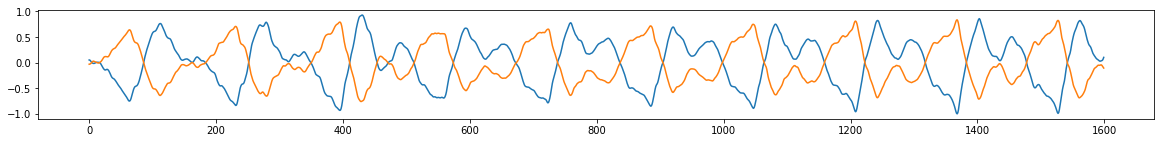

0.053863525390625


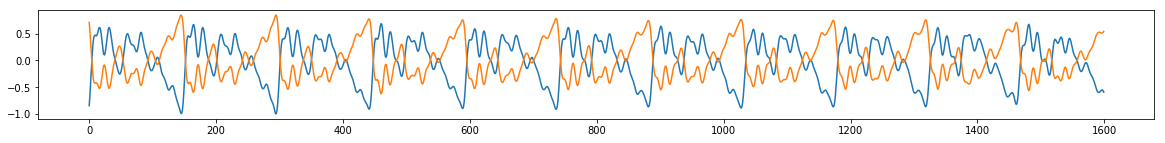

0.0712890625


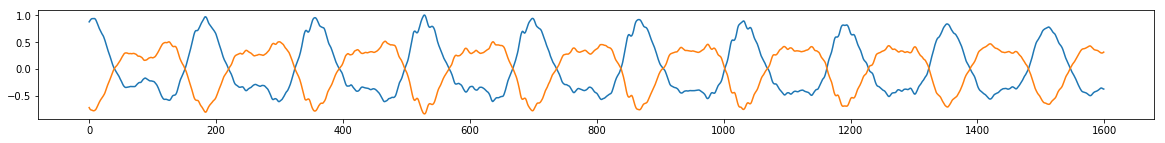

amp


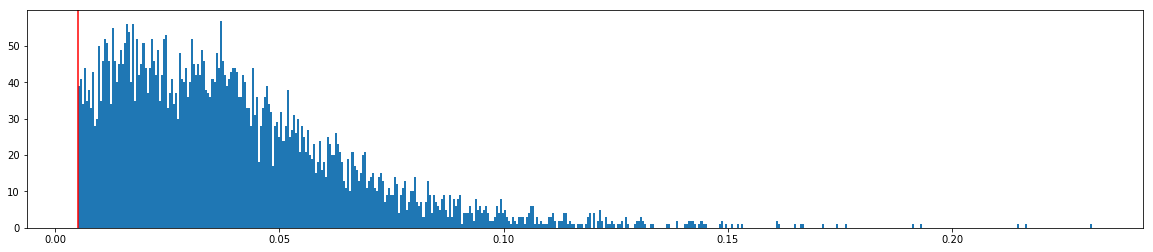

data.shape == (5672, 1600, 2)
amp.shape == (5672,)


In [12]:
data, amp = gen.generate(0, DEMO=True)

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [14]:
# ls ./model/

In [15]:
saver = tf.train.Saver()
# saver.restore(sess, './model/model-c-89')

# ガクッとloss下がった（43~40->29）

In [17]:
# saver.save(sess, './model/model-c', global_step=epoch)

In [16]:
batch_size = 128
max_epoch = 10

for epoch in range(max_epoch):
    
    for file in range(len(files)):
        
        data, _ = gen.generate(file)
        
        loss_hist = []
        for index in tqdm(range(0, len(data), batch_size)):
            batch = data[index:index+batch_size]
            _, _loss = sess.run([optimize, loss], {inputs: batch})
            loss_hist.append(_loss)
#             _, _loss0, _loss1, _loss2, _loss = sess.run([optimize, loss0, loss1, loss2, loss], {inputs: batch})
        print("epoch:", epoch+1, "file:", file+1, ", loss_sum:", np.mean(loss_hist))
    saver.save(sess, './model/model', global_step=epoch)
saver.save(sess, './model/model-c', global_step=epoch)

100%|██████████| 45/45 [00:06<00:00,  6.64it/s]


epoch: 1 file: 1 , loss_sum: 281.34973


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 1 file: 2 , loss_sum: 101.88458


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 1 file: 3 , loss_sum: 72.97722


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 4 , loss_sum: 62.58917


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1 file: 5 , loss_sum: 51.141064


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 6 , loss_sum: 68.562195


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 7 , loss_sum: 55.409973


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 8 , loss_sum: 45.56659


100%|██████████| 45/45 [00:05<00:00,  8.44it/s]


epoch: 1 file: 9 , loss_sum: 42.021442


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 2 file: 1 , loss_sum: 31.16738


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 2 file: 2 , loss_sum: 32.387535


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 2 file: 3 , loss_sum: 35.01448


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 4 , loss_sum: 34.976322


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 2 file: 5 , loss_sum: 38.49881


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 6 , loss_sum: 49.214027


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 7 , loss_sum: 42.239613


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 8 , loss_sum: 35.21481


100%|██████████| 45/45 [00:05<00:00,  8.54it/s]


epoch: 2 file: 9 , loss_sum: 32.957134


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 3 file: 1 , loss_sum: 24.631695


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 3 file: 2 , loss_sum: 26.945799


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 3 file: 3 , loss_sum: 29.520025


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3 file: 4 , loss_sum: 31.805933


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 3 file: 5 , loss_sum: 30.903463


100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


epoch: 3 file: 6 , loss_sum: 43.16893


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 7 , loss_sum: 38.442944


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 8 , loss_sum: 33.4291


100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


epoch: 3 file: 9 , loss_sum: 31.06131


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 4 file: 1 , loss_sum: 22.763063


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 4 file: 2 , loss_sum: 24.297226


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 4 file: 3 , loss_sum: 27.118845


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4 file: 4 , loss_sum: 28.332376


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 4 file: 5 , loss_sum: 28.922792


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4 file: 6 , loss_sum: 40.723717


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 7 , loss_sum: 36.394066


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 8 , loss_sum: 31.696232


100%|██████████| 45/45 [00:05<00:00,  8.67it/s]


epoch: 4 file: 9 , loss_sum: 28.76818


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 5 file: 1 , loss_sum: 21.725536


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 5 file: 2 , loss_sum: 23.43616


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 5 file: 3 , loss_sum: 26.778973


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5 file: 4 , loss_sum: 27.750996


100%|██████████| 48/48 [00:05<00:00,  8.26it/s]


epoch: 5 file: 5 , loss_sum: 26.739357


100%|██████████| 50/50 [00:06<00:00,  8.30it/s]


epoch: 5 file: 6 , loss_sum: 38.180298


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 7 , loss_sum: 35.102165


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 8 , loss_sum: 30.528255


100%|██████████| 45/45 [00:05<00:00,  8.71it/s]


epoch: 5 file: 9 , loss_sum: 28.85115


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 6 file: 1 , loss_sum: 20.280468


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 6 file: 2 , loss_sum: 22.499983


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 6 file: 3 , loss_sum: 24.94358


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 4 , loss_sum: 27.41999


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 6 file: 5 , loss_sum: 29.897156


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 6 , loss_sum: 37.256126


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 7 , loss_sum: 33.53213


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 8 , loss_sum: 29.636078


100%|██████████| 45/45 [00:05<00:00,  8.55it/s]


epoch: 6 file: 9 , loss_sum: 27.01587


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 7 file: 1 , loss_sum: 19.271856


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 7 file: 2 , loss_sum: 21.707672


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 7 file: 3 , loss_sum: 24.471731


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 4 , loss_sum: 25.328655


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 7 file: 5 , loss_sum: 25.604197


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 6 , loss_sum: 35.59027


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 7 , loss_sum: 32.59873


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 8 , loss_sum: 29.13995


100%|██████████| 45/45 [00:05<00:00,  8.54it/s]


epoch: 7 file: 9 , loss_sum: 26.267979


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 8 file: 1 , loss_sum: 18.909134


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 8 file: 2 , loss_sum: 21.321865


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 8 file: 3 , loss_sum: 24.195887


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 4 , loss_sum: 24.74638


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 8 file: 5 , loss_sum: 26.18075


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 6 , loss_sum: 35.933746


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 7 , loss_sum: 32.561962


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 8 , loss_sum: 28.394182


100%|██████████| 45/45 [00:05<00:00,  8.57it/s]


epoch: 8 file: 9 , loss_sum: 25.826145


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 9 file: 1 , loss_sum: 19.16685


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 9 file: 2 , loss_sum: 20.764423


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 9 file: 3 , loss_sum: 23.5491


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9 file: 4 , loss_sum: 24.644682


100%|██████████| 48/48 [00:05<00:00,  8.56it/s]


epoch: 9 file: 5 , loss_sum: 24.85074


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9 file: 6 , loss_sum: 34.552048


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 7 , loss_sum: 31.635979


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 8 , loss_sum: 28.261627


100%|██████████| 45/45 [00:05<00:00,  8.53it/s]


epoch: 9 file: 9 , loss_sum: 24.745026


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 10 file: 1 , loss_sum: 18.102367


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 10 file: 2 , loss_sum: 20.774754


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 10 file: 3 , loss_sum: 23.232384


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 4 , loss_sum: 25.035088


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 10 file: 5 , loss_sum: 24.364878


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 6 , loss_sum: 34.005642


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 7 , loss_sum: 32.08916


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 8 , loss_sum: 27.717009


100%|██████████| 45/45 [00:05<00:00,  8.56it/s]


epoch: 10 file: 9 , loss_sum: 24.774998


'./model/model-c-9'

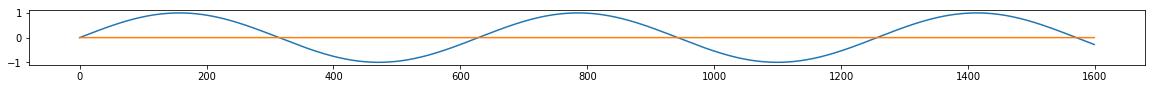

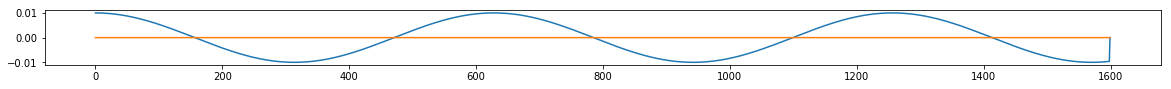

In [24]:
def df(f):
    df = np.zeros((len(f),2))
    df[:-1] = f[1:] - f[:-1]
    return df
_x = np.zeros((1600,2))
_x[:,0] = np.sin(np.arange(1600)/100.0) # y = sin(x/100) dy/dx = 1/100*cos(x/100)
plt.figure(figsize=(20,1))
plt.plot(_x)
plt.show()
plt.figure(figsize=(20,1))
plt.plot(df(_x))
plt.show()

def denoise(f):
    v = np.ones(8)/8
    f = np.array([np.convolve(fi,v, mode='same') for fi in f.T]).T
    return f
# _x = np.zeros((1600,2))
# _x[:,0] = np.sin(np.arange(1600)/100.0)
# _x += np.random.randn(1600,2)/10
# plt.figure(figsize=(20,1))
# plt.plot(_x)
# plt.show()
# plt.figure(figsize=(20,1))
# plt.plot(denoise(_x))
# plt.show()
# plt.figure(figsize=(20,1))
# plt.plot(denoise(denoise(_x)))
# plt.show()

(1600, 2) amp: 0.016876220703125
original


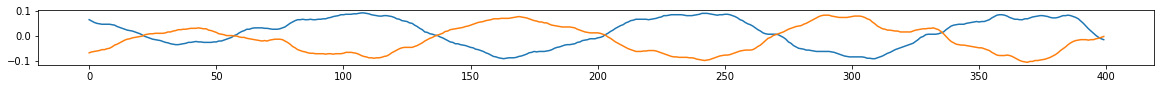

df


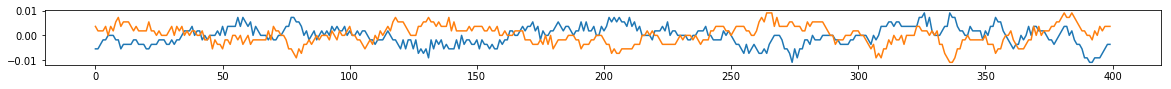

ddf


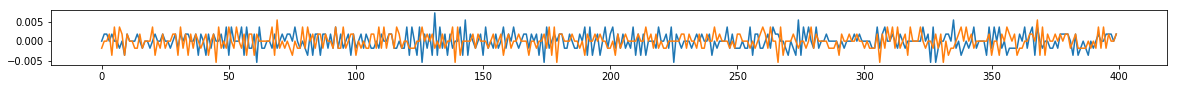

ae


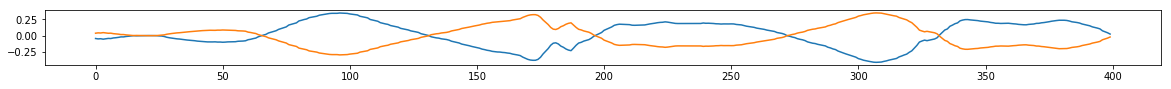

df


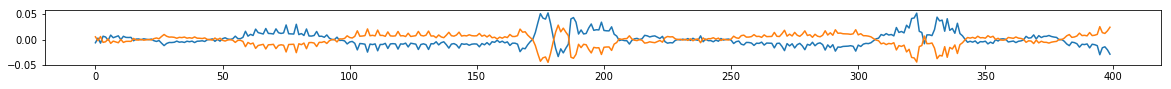

ddf


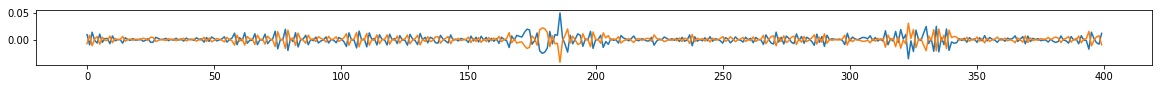

In [26]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a)
_x = x.reshape(wave_len, data_dim)
print("original")
plt.figure(figsize=(20,1))
plt.plot(_x[:400])
plt.show()
print("df")
plt.figure(figsize=(20,1))
plt.plot(df(_x)[:400])
plt.show()
print("ddf")
plt.figure(figsize=(20,1))
plt.plot(df(df(_x))[:400])
plt.show()
print("ae")
x = sess.run(decoded, {inputs: [_x]})
x = x[0].reshape(wave_len, data_dim)
plt.figure(figsize=(20,1))
plt.plot(x[:400])
plt.show()
print("df")
plt.figure(figsize=(20,1))
plt.plot(df(x)[:400])
plt.show()
print("ddf")
plt.figure(figsize=(20,1))
plt.plot(df(df(x))[:400])
plt.show()

(1600, 2) amp: 0.02728271484375
original


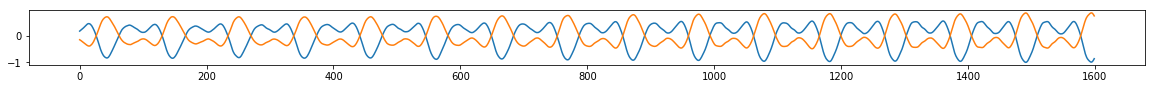

df


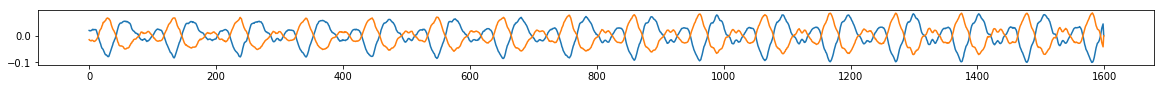

ddf


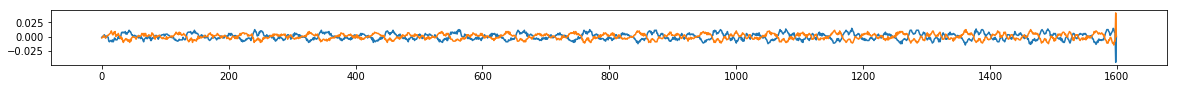

ae


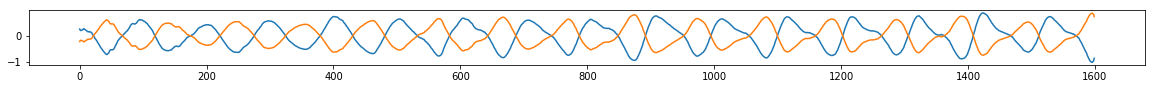

df


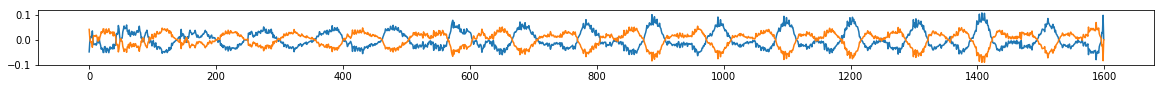

ddf


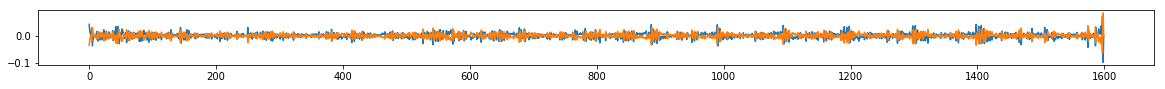

f+df


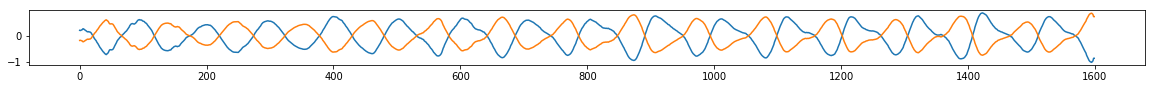

In [57]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a)
_x = x.reshape(wave_len, data_dim)
print("original")
plt.figure(figsize=(20,1))
plt.plot(_x)
plt.show()
print("df")
plt.figure(figsize=(20,1))
plt.plot(df(_x))
plt.show()
print("ddf")
plt.figure(figsize=(20,1))
plt.plot(df(df(_x)))
plt.show()
print("ae")
x = sess.run(decoded, {inputs: [_x]})
x = x[0].reshape(wave_len, data_dim)
plt.figure(figsize=(20,1))
plt.plot(x)
plt.show()
print("df")
plt.figure(figsize=(20,1))
plt.plot(df(x))
plt.show()
print("ddf")
plt.figure(figsize=(20,1))
plt.plot(df(df(x)))
plt.show()
print("f+df")
plt.figure(figsize=(20,1))
a = x+df(x)
plt.plot(a)
plt.show()

(1600, 2) amp: 0.06427001953125
original


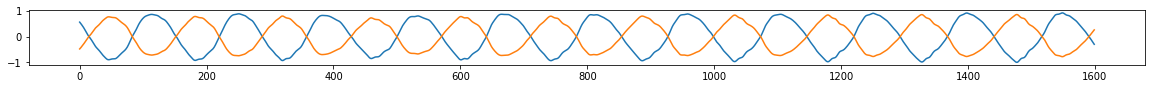

decoded
(1, 1600, 2)


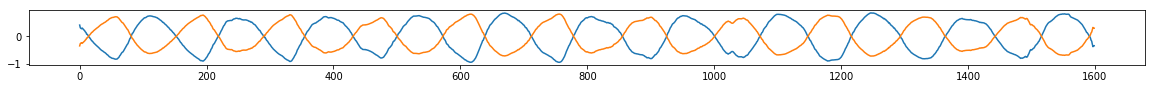

inputs_dt
(1, 1600)


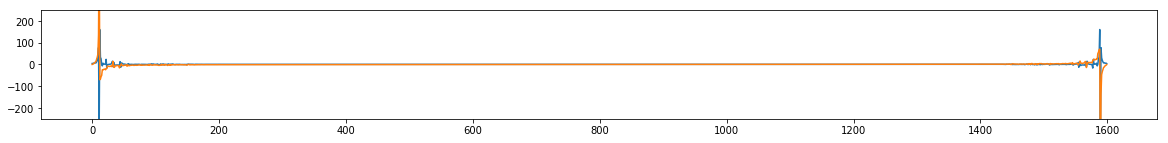

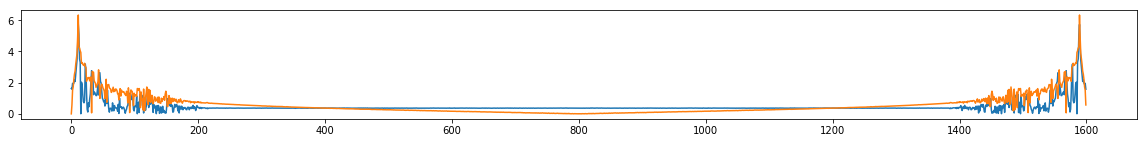

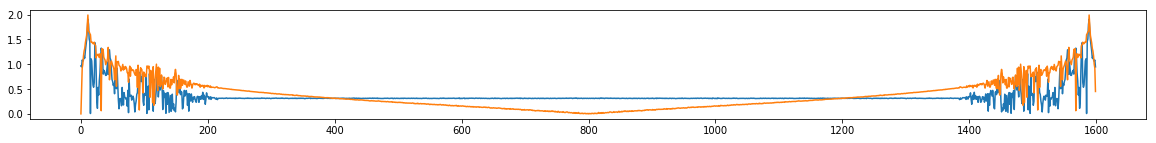

decoded_dt


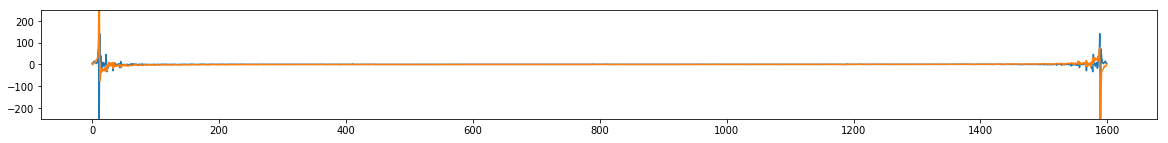

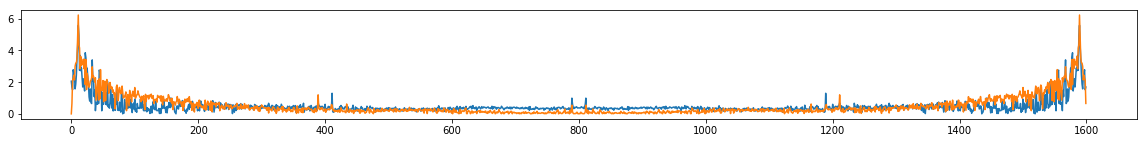

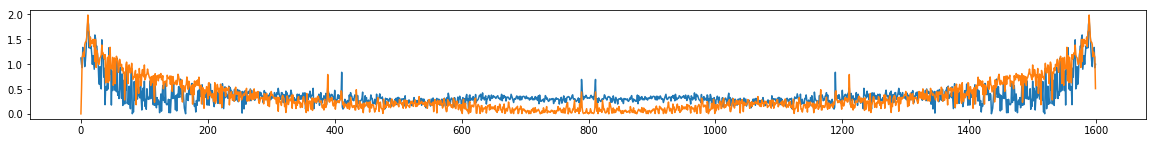

In [65]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a)
_x = x.reshape(wave_len, data_dim)
print("original")
plt.figure(figsize=(20,1))
plt.plot(_x)
plt.show()

x = sess.run(decoded, {inputs: [_x]})
print("decoded")
print(x.shape)
plt.figure(figsize=(20,1))
plt.plot(x[0])
plt.show()

x = sess.run(inputs_fft_0, {inputs: [_x]})
print("inputs_dt")
print(x.shape)
plt.figure(figsize=(20,2));plt.ylim([-250,250])
A1 = np.real(x.T)
A2 = np.imag(x.T)
plt.plot(A1)
plt.plot(A2)
plt.show()
plt.figure(figsize=(20,2))
plt.plot(np.log(np.abs(A1)+1))
plt.plot(np.log(np.abs(A2)+1))
plt.show()
plt.figure(figsize=(20,2))
plt.plot(np.log(np.log(np.abs(A1)+1)+1))
plt.plot(np.log(np.log(np.abs(A2)+1)+1))
plt.show()

x = sess.run(decoded_fft_0, {inputs: [_x]})
print("decoded_dt")
plt.figure(figsize=(20,2));plt.ylim([-250,250])
B1 = np.real(x.T)
B2 = np.imag(x.T)
plt.plot(B1)
plt.plot(B2)
plt.show()
plt.figure(figsize=(20,2))
plt.plot(np.log(np.abs(B1)+1))
plt.plot(np.log(np.abs(B2)+1))
plt.show()
plt.figure(figsize=(20,2))
plt.plot(np.log(np.log(np.abs(B1)+1)+1))
plt.plot(np.log(np.log(np.abs(B2)+1)+1))
plt.show()

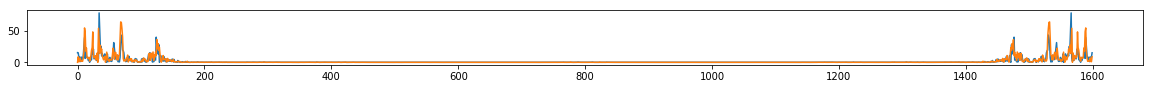

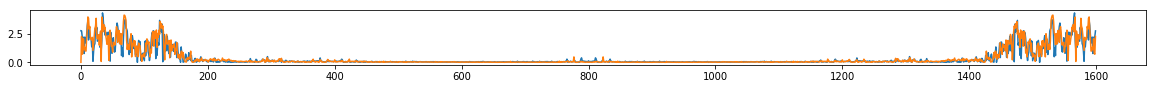

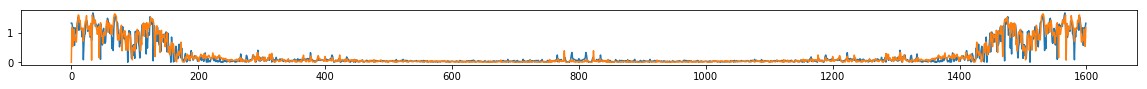

In [82]:
plt.figure(figsize=(20,1))
plt.plot(np.abs(A1-B1))
plt.plot(np.abs(A2-B2))
plt.show()
plt.figure(figsize=(20,1))
plt.plot(np.log(np.abs(A1-B1)+1))
plt.plot(np.log(np.abs(A2-B2)+1))
plt.show()
plt.figure(figsize=(20,1))
plt.plot(np.log(np.log(np.abs(A1-B1)+1)+1))
plt.plot(np.log(np.log(np.abs(A2-B2)+1)+1))
plt.show()

In [ ]:
show(_x)

In [ ]:
show(x[0].reshape(wave_len, data_dim))

In [389]:
saver.save(sess, './model/model-powloss', global_step=epoch)

'./model/model-powloss-89'

In [20]:
# gen = Generator_for_realtime()
gen = Generator()

In [21]:
data, amp = gen.generate(0)

# 声のデコードするぞい
# 同じ値で割ったほうがいい？

### ファイル6使ったら？

In [ ]:
def sigmoid(x):
    x = (x - np.mean(x))*10
    y = 1 / (1 + np.e**-x)
    return y

def connect(x1, x2, DEMO=False):
    
    if DEMO:
        x = np.vstack([x1,x2])
        print(x.shape)
        plt.figure(figsize=(20,2))
        plt.plot(x)
        plt.axvline(len(x1)-1, linewidth=0.5)
        plt.show()
    
    l = int(round(len(x1)*0.2))
    if l < 5: l = len(x1)
    if l > len(x2): l = len(x2)
#     if l > len(x1):
#     l = min(l, len(x1)-1, len(x2)-1)
#     print(l)
    a1 = x1[:-l] # これでlがはみ出てたらまずい
    a2 = x1[-l:]
    b1 = x2[:l]
    b2 = x2[l:]
    
    w = np.linspace(0,1,l)
    w = sigmoid(w)
    c = a2*np.array([(1-w)]).T + b1*np.array([w]).T
    x = np.vstack([a1,c, b2])

    if DEMO:
        print("l ==", l)
        print(x1.shape, x2.shape)
        print(a1.shape, a2.shape, b1.shape, b2.shape)
        plt.figure(figsize=(20,2))
        plt.axvline(len(a1)-1, linewidth=0.5)
        plt.axvline(len(a1)+len(c)-1, linewidth=0.5)
        plt.plot(x)
        plt.show()
    return x

In [32]:
ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = gen.generate(fi, shuffle=False, NO_SILENT=False)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 1600,2):
            continue
        # denoiseしたほうが良いよ！！！！！
#         ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))
        batch_data = np.array([denoise(_data) for _data in batch_data])
        batch_data = np.array([denoise(_data) for _data in batch_data]) # denoise2回する
        ae_data.extend(batch_data*batch_amp.reshape(-1,1,1))

100%|██████████| 51/51 [00:02<00:00, 20.15it/s]


(1600, 2) (1560, 2)


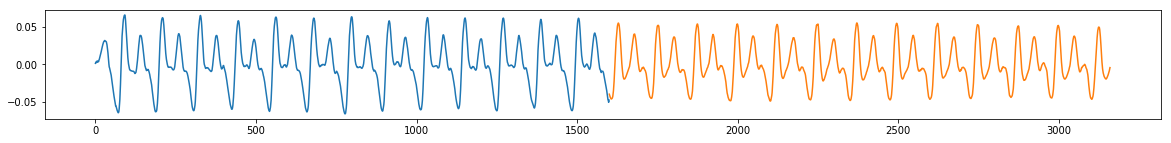

In [58]:
plt.figure(figsize=(20,2))
print(A.shape, B.shape)
plt.plot(np.arange(len(A)), A[:,0])
plt.plot(np.arange(len(A),len(A)+len(B)), B[:,0])
plt.show()

In [23]:
51+55+53+51+53+55+54+51+49-9

463

In [33]:
ae_data = np.array(ae_data).reshape(-1, data_dim)
print(ae_data.shape)


(10240000, 2)


In [19]:
ae_data.shape[0]/1600/128

50.0

In [20]:
np.save("autoencoded.npy", ae_data)

In [21]:
9075200 / 3.16 / 60

47864.97890295358

In [22]:
print(ae_data.shape)

(10240000, 2)


In [34]:
sf.write("temp_denoise.wav", ae_data, rate)
# sf.write("aevoice_freq_64_10dt10ddt.wav", ae_data, rate)

In [69]:
55*128*1600

11264000

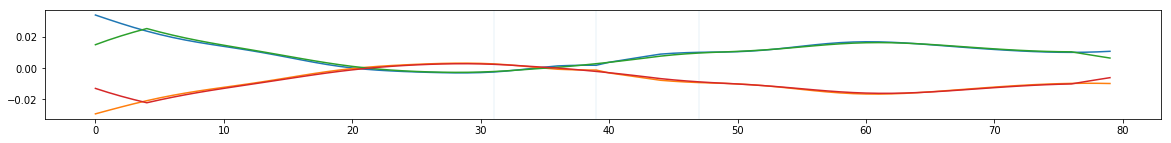

-644683837890609/100000000000000000 160095095634457/25000000000000000
1418471336364648/4303455352781 478153460647937631786800921/4303455352781000000000000000
51121413707733/12500000000000000 -438123941421507/100000000000000000
2097641980206/1079727102209 623866761049774055080315857/53986355110450000000000000000


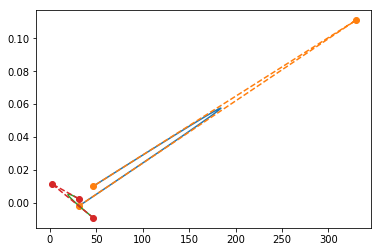

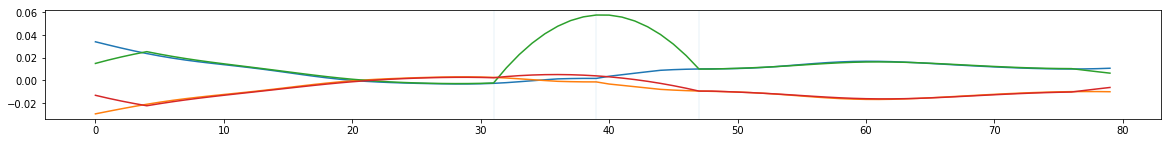

In [374]:
k = np.random.randint(54*128)
plt.figure(figsize=(20,2))
# plt.plot(ae_data[k*1600:(k+1)*1600])

w = 40

_X = ae_data[k*1600-w:k*1600+w]

X = denoise(_X)

plt.plot(_X)
plt.plot(X)
plt.axvline(w-1, linewidth=0.1)
plt.axvline(w-1+8, linewidth=0.1)
plt.axvline(w-1-8, linewidth=0.1)
plt.show()


p1 = [30, X[30,0]]
p3 = [32, X[32,0]]
p2 = [46, X[47,0]]
p4 = [48, X[49,0]]

pa = [31, X[31,0]]
pb = [47, X[48,0]]
pc = cross_point(Point(p1), Point(p2), Point(p3), Point(p4))

q = np.array([pa, pc, pb], dtype=np.float)

list = []
for t in np.linspace(0, 1, 17):
    list.append(bezier(2, t, q))
P1 = np.array(list)

plt.plot(P1.T[0], P1.T[1])
plt.plot(q.T[0], q.T[1], '--o')

p1 = [30, X[30,1]]
p3 = [32, X[32,1]]
p2 = [46, X[47,1]]
p4 = [48, X[49,1]]

pa = [31, X[31,1]]
pb = [47, X[48,1]]
pc = cross_point(Point(p1), Point(p2), Point(p3), Point(p4))

q = np.array([pa, pc, pb], dtype=np.float)

list = []
for t in np.linspace(0, 1, 17):
    list.append(bezier(2, t, q))
P2 = np.array(list)

plt.plot(P2.T[0], P2.T[1])
plt.plot(q.T[0], q.T[1], '--o')
plt.show()


plt.figure(figsize=(20,2))
plt.plot(_X)
plt.axvline(w-1, linewidth=0.1)
plt.axvline(w-1+8, linewidth=0.1)
plt.axvline(w-1-8, linewidth=0.1)

X[31:48,0] = P1.T[1]
X[31:48,1] = P2.T[1]
plt.plot(X)

plt.show()


In [154]:
from sympy import *
sg1,sg2 = Segment( Point(0,0), Point(1,1)),Segment( Point(0,1), Point(1,0))
ls = intersection(sg1,sg2)
print(ls)

ls = intersection(sg1,sg2)[0]
print(ls,ls.x,ls.y)

sg1,sg2 = Segment( Point(0,0), Point(0.3,0.3)), Segment( Point(0,1), Point(1,0))
ls = intersection(sg1,sg2)
print(ls)

[Point2D(1/2, 1/2)]
Point2D(1/2, 1/2) 1/2 1/2
[]


In [163]:
A = Point(0,1)
A.y

1

In [266]:
def cross_point(p1, p2, p3, p4):
    s1 = ((p4.x - p2.x) * (p1.y - p2.y) - (p4.y - p2.y) * (p1.x - p2.x))/2
    s2 = ((p4.x - p2.x) * (p2.y - p3.y) - (p4.y - p2.y) * (p2.x - p3.x))/2
    print(s1, s2)
    (x,y) =  p1.x + (p3.x - p1.x) * s1 / (s1 + s2), p1.y + (p3.y - p1.y) * s1 / (s1 + s2)
    print(x,y)
    return [x,y]
cross_point(Point([0,0]), Point(0,5), Point(0.1,0.1), Point(-1,0))

5/2 -27/10
-5/4 -5/4


[-5/4, -5/4]

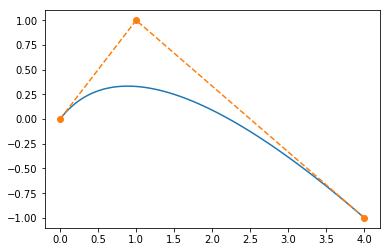

In [132]:
import scipy.special as scs
import numpy as np
import matplotlib.pyplot as plt

def bernstein(n, i, t):
    return scs.comb(n, i) * t**i * (1 - t)**(n-i)

def bezier(n, t, q):
    p = np.zeros(2)
    for i in range(n + 1):
        p += bernstein(n, i, t) * q[i]
    return p

q = np.array([[0, 0], [1, 1], [4, -1]], dtype=np.float)

list = []
for t in np.linspace(0, 1, 100):
    list.append(bezier(2, t, q))
P = np.array(list)

plt.plot(P.T[0], P.T[1])
plt.plot(q.T[0], q.T[1], '--o')
plt.show()

# 1024の推移をプロットする

In [ ]:
N = 1600#rate            # サンプル数
dt = 1/48000
t = np.arange(0, N*dt, dt) # 時間軸
freq = np.fft.fftfreq(N, d=dt) # 周波数

def show(f):
    f0 = f[:,0]
    f1 = f[:,1]
    
#     plt.figure(figsize=(20,2))
#     plt.plot(f0)
#     plt.plot(f1)
#     plt.show()

    F0 = np.fft.fft(f0)
    F1 = np.fft.fft(f1)

#     plt.figure(figsize=(20,2))
#     plt.plot(F0)
#     plt.plot(F1)
#     plt.show()
    
    plt.figure(figsize=(20,2))
    plt.plot(freq[1:int(N/2)][:200], F0[1:int(N/2)][:200].real)
    plt.plot(freq[1:int(N/2)][:200], F0[1:int(N/2)][:200].imag)
    plt.plot(freq[1:int(N/2)][:200], F1[1:int(N/2)][:200].real)
    plt.plot(freq[1:int(N/2)][:200], F1[1:int(N/2)][:200].imag)
    plt.show()

    F0 = F0/(N/2)
    F1 = F1/(N/2)
    F0[0] = F0[0]/2
    F1[0] = F1[0]/2

    G0 = F0.copy()
    G1 = F1.copy()
#     G0[(freq > fc)] = 0
#     G1[(freq > fc)] = 0
#     G0[(freq < fd)] = 0
#     G1[(freq < fd)] = 0

#     plt.figure(figsize=(20,2))
#     plt.plot(freq[1:int(N/2)][:200], G0[1:int(N/2)][:200])
#     plt.plot(freq[1:int(N/2)][:200], G1[1:int(N/2)][:200])
#     plt.show()
    
    f0 = np.fft.ifft(G0)
    f1 = np.fft.ifft(G1)
    f0 = np.real(f0*N)
    f1 = np.real(f1*N)
    
#     plt.figure(figsize=(20,2))
#     plt.plot(f0)
#     plt.plot(f1)
#     plt.show()
    
    f = np.c_[f0, f1]